In [1]:
import os
import numpy as np
import torch
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from time import time
from skimage.io import imread
from utils import util
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes
from torch.utils.data import DataLoader
from networks.flame_extractor import Extractor
from munch import DefaultMunch
import warnings
warnings.filterwarnings('ignore')
from datasets.align import AlignDataset
import albumentations as albu
import albumentations.pytorch
import cv2
import cv2
import os
from PIL import Image
import numpy as np
import shutil
import json


In [2]:

cfg_dict = {
  "device": "cuda:0",
  "random_seed": 0,
  "DECA_kwargs": {
    "pretrained_model" : '/src/deca/DECA/data/deca_model.tar',
    "topology_path": '/src/deca/DECA/data/head_template.obj',
    'dense_template_path': '/src/deca/DECA/data/texture_data_256.npy',
    'fixed_displacement_path': '/src/deca/DECA/data/fixed_displacement_256.npy',
    'flame_model_path': '/src/deca/DECA/data/generic_model.pkl',
    'flame_lmk_embedding_path': '/src/deca/DECA/data/landmark_embedding.npy',
    'face_mask_path': '/src/deca/DECA/data/uv_face_mask.png',
    'face_eye_mask_path': '/src/deca/DECA/data/uv_face_eye_mask.png',
    'mean_tex_path': '/src/deca/DECA/data/mean_texture.jpg',
    'tex_path': '/src/deca/DECA/data/FLAME_albedo_from_BFM.npz',
    'tex_type': 'BFM',
    'image_size': 224,
    'uv_size': 256,
    'param_list': ['shape', 'tex', 'exp', 'pose', 'cam', 'light'],
    'n_shape': 100,
    'n_tex': 50,
    'n_exp': 50,
    'n_cam': 3,
    'n_pose': 6,
    'n_light': 27,
    'use_tex': True, 
    'jaw_type': 'euler',
    'fr_model_path': '/src/deca/DECA/data/resnet50_ft_weight.pkl', 
    'n_detail': 128, 
    'max_z': 0.01,
    'jaw_type' : 'euler'
  }
}

cfg = DefaultMunch.fromDict(cfg_dict)




In [3]:
# %%
net = Extractor(cfg)
device = net.device

transforms = albu.Compose([
    albu.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255, always_apply=True, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()])


imgs_path = '/src/data/raw_data/images1024x1024'
keypoints_path = "/src/data/raw_data/ffhq.json"

dataset = AlignDataset(imgs_path, keypoints_path, transforms)




creating the FLAME Decoder
DECA trained model found. load /src/deca/DECA/data/deca_model.tar


In [4]:
# %%
batch_size = 35
num_workers = 0
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)



In [5]:
save_path = "/src/data/raw_data/ffhq/"
os.makedirs(save_path, exist_ok=True)


from utils.tensor_cropper import transform_points


In [6]:
idx = 0
mask = net.uv_face_eye_mask
mask[mask > 0] = 1
mask = mask.cpu().squeeze(0).numpy()
kernel = np.ones((15,15),np.uint8)
net.uv_face_eye_mask = torch.FloatTensor(cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)).to(device).unsqueeze(0)

for i, data in enumerate(train_loader):
    imgs = data[1].to(device)
    imgs_orig = data[0].to(device)
    tform = data[3]
    tform = torch.inverse(tform).transpose(1,2).to(device)
    keypoints = data[2]
    with torch.no_grad():
        codedict = net.encode(imgs)

    shapecode = codedict['shape']
    expcode = codedict['exp']
    posecode = codedict['pose']
    texcode = codedict['tex']
    lightcode = codedict['light']
    detailcode = codedict['detail']
    cam = codedict['cam']

    ## decode
    verts, landmarks2d, landmarks3d = net.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])


    landmarks3d_world = landmarks3d.clone()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, codedict['cam'])[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, codedict['cam']); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]
    
    points_scale = [224, 224]
    h, w = 256, 256

    trans_verts = transform_points(trans_verts, tform, points_scale, [h, w])
    landmarks2d = transform_points(landmarks2d, tform, points_scale, [h, w])
    landmarks3d = transform_points(landmarks3d, tform, points_scale, [h, w])

    with torch.no_grad():
        albedo = net.flametex(texcode)
        displacement_map = net.D_detail(torch.cat([posecode[:,3:], expcode, detailcode], dim=1))

    # rendering
    ops = net.render.render_orig(verts, trans_verts, albedo, lightcode, h=h, w=w) 


    uv_detail_normals = net.displacement2normal(displacement_map, verts, ops['normals'])
    uv_shading = net.render.add_SHlight(uv_detail_normals, lightcode)


    # # segmentation
    visibility_mask =  ops['alpha_images']
    grid = ops["grid"]
    shading = F.grid_sample(uv_shading, grid, align_corners=False)
    face_eye = F.grid_sample(torch.cat(len(imgs)*[net.uv_face_eye_mask]), ops['grid'], align_corners=False) * visibility_mask
    landmarks_deca = landmarks2d * 128 + 128
    landmarks_orig = keypoints
    for d in zip(visibility_mask, grid, shading, face_eye, landmarks_deca, landmarks_orig, shapecode, expcode, posecode, texcode, lightcode, detailcode, cam, imgs_orig):
        idx = idx + 1 
        new_ops = {}
        new_ops["visibility_mask"] = d[0].cpu()
        new_ops["grid"] = d[1].cpu()
        new_ops["shading_mask"] = d[2].cpu()
        new_ops["face_eye_mask"] = d[3].cpu()
        new_ops["dst_lmks"] = d[4].cpu()
        new_ops["src_lmks"] = d[5].cpu()
        new_ops["shapecode"] = d[6].cpu()
        new_ops["expcode"] = d[7].cpu()
        new_ops["posecode"] = d[8].cpu()
        new_ops["texcode"] = d[9].cpu()
        new_ops["lightcode"] = d[10].cpu()
        new_ops["detailcode"] = d[11].cpu()
        new_ops["cam"] = d[12].cpu()
        new_ops["img"] = d[13].cpu()

        np.save(os.path.join(save_path, str(idx)), new_ops)



    if(i % 100 == 0):
        print(i)


    





0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


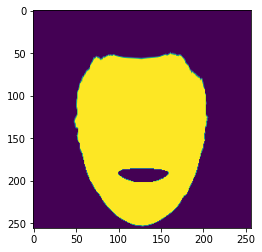

In [7]:
grid = ops["grid"]
import matplotlib.pyplot as plt
# shading = F.grid_sample(uv_face_eye, grid, align_corners=False)
plt.figure()
plt.imshow(face_eye[0].permute(1, 2, 0).cpu())

In [8]:
net.uv_face_eye_mask.shape

torch.Size([1, 1, 256, 256])

<AxesSubplot:>

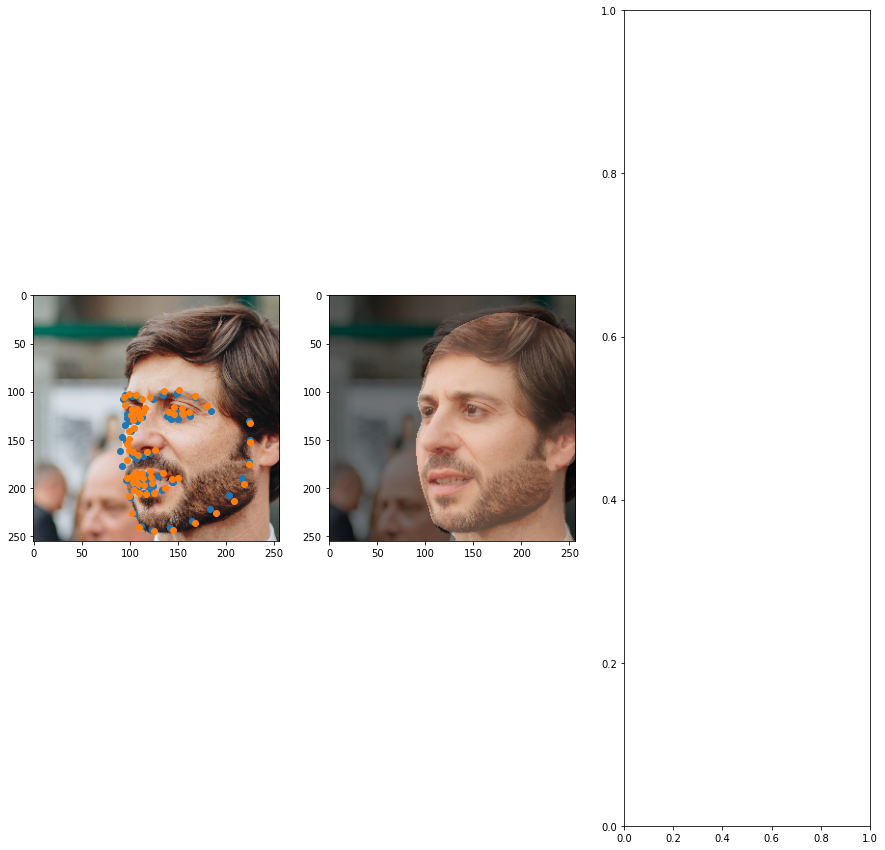

In [9]:
import matplotlib.pyplot as plt
idx = 1
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(data[0][idx].permute(1, 2, 0))

plt.scatter(landmarks2d[idx][:, 0].cpu() * 128 + 128 , landmarks2d[idx][:, 1].cpu() *128 + 128)
plt.scatter(keypoints[idx][:, 0].cpu() , keypoints[idx][:, 1].cpu())

plt.subplot(1, 3, 2)

plt.imshow(0.5 * ops['images'][idx].permute(1, 2, 0).cpu() + imgs_orig[idx].permute(1, 2, 0).cpu() * 0.5)
plt.subplot(1, 3, 3)





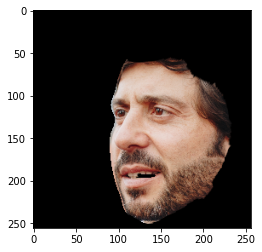

In [10]:
plt.imshow(imgs_orig[idx].permute(1, 2, 0).cpu() * face_eye[idx].permute(1, 2, 0).cpu())


In [11]:
plt.imshow(ops[0][0].permute(1, 2, 0).cpu())


KeyError: 0

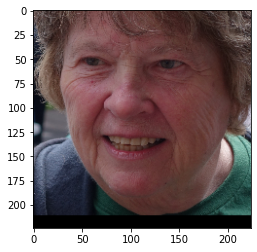

In [ ]:
plt.imshow(data[1][0].permute(1, 2, 0))


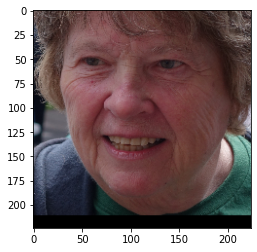

In [ ]:
plt.imshow(data[1][0].permute(1, 2, 0))
